## Import the necessary header files required

Check whether you have GPU availablity since training in CPU is very slow

Prerequisites: 
* Knows intermediate python
* Classification problems in machine learning
* How **Forward prop** and **Back prop** works in neural nets
* Basics of gradient descent (also nice to know kinds of parameter updates)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

In [2]:
picture_size = 48
folder_path = "../input/face-expression-recognition-dataset/images/"

## Data loading and preprocessing

Here there isn't much of data preprocessing going on, The horizontal_flip flips images randomly so our model is more robust

The flow_from_directory part in tensorflow takes care of target labels(y, which in our case is the name of the folder) and features(x)

In [3]:
batch_size  = 64

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## Building our neural network

This is completely upto your choice you can prefer any kind of structure that you want.

*In torch make sure your conv and pool dimensions are proper* or else the matrices/tensors can't undergo proper matrix multipilcation.

***Remember to flatten for shifting from convolutional layers to fully connected layers***

The ReduceLROnPlateau reduces the learning rate whenever our network is stuck at a local minima.

### Important formulas for calculating dimensions

* Output of conv layer would have dimension -> ((H - F + 2P)//s) + 1 *we can't have decimals here*

  *where H - height of input(in our case image) , F - kernel_size(filter size) , P - padding & s - stride (vice versa for width)* 
  
  
* If you want the input dimensions (height & width) to remain same then you can use this -> (F - 1)/2

  *where F - kernel_size(filter size)*

In [4]:
from keras.optimizers import Adam,SGD,RMSprop
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolution layer
model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolution layer
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4th Convolution layer
model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
model.add(Flatten())
model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 128)       0

## Training the model

* This takes care of training our model, in tensorflow we have this fit method which does all the things for us like predicting on validation and training images.
* The ModelCheckpoint saves our best weights so that we can use it in our test time.

In [5]:
epochs = 15

from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau


checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
callbacks_list = [checkpoint,reduce_lr]

history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
450/450 [==============================] - 179s 392ms/step - loss: 1.8491 - accuracy: 0.3394 - val_loss: 1.5417 - val_accuracy: 0.4503
Epoch 2/15
450/450 [==============================] - 24s 52ms/step - loss: 1.3106 - accuracy: 0.5052 - val_loss: 1.2848 - val_accuracy: 0.5128
Epoch 3/15
450/450 [==============================] - 24s 53ms/step - loss: 1.1480 - accuracy: 0.5688 - val_loss: 1.4119 - val_accuracy: 0.4726
Epoch 4/15
450/450 [==============================] - 24s 53ms/step - loss: 1.0120 - accuracy: 0.6241 - val_loss: 1.2135 - val_accuracy: 0.5558
Epoch 5/15
450/450 [==============================] - 24s 52ms/step - loss: 0.9008 - accuracy: 0.6682 - val_loss: 1.4674 - val_accuracy: 0.4641
Epoch 6/15
450/450 [==============================] - 24s 53ms/step - loss: 0.8131 - accuracy: 0.7013 - val_loss: 1.1932 - val_accuracy: 0.5713
Epoch 7/15
450/450 [==============================] - 24s 53ms/step - loss: 0.6785 - accuracy: 0.7546 - val_loss: 1.3148 - val_accurac

# Saving the Model

In [6]:
model.save_weights("./model.h5")

# Plotting Accuracy & Loss

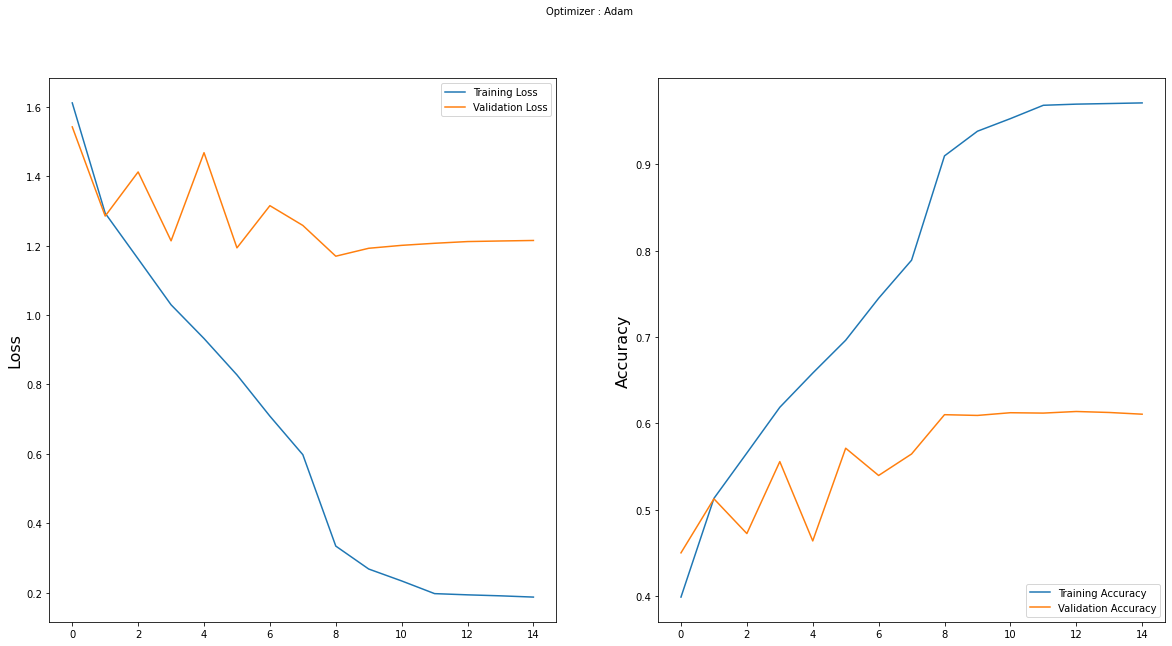

In [7]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()